In [1]:
from src.implementations import *

import numpy as np
import pandas as pd

import zipfile
import warnings

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from transformers import AutoTokenizer, AutoModel
import torch
import umap

In [2]:
# Ignore benign warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# <b><u> Data Loading </u></b> #

We load only the relevant columns since the dataset is already quite large (3 million rows).

In [3]:
zip_file_path = 'BindingDB_All_202409_tsv.zip'
file_path = 'BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Institution', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.head()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_22348\2386863531.py:13: DtypeWarning: Columns (8,9,10,11,12,13,15,23,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


Ligand SMILES  \
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   

                              Target Name  \
0  Dimer of Gag-Pol polyprotein [501-599]   
1  Dimer of Gag-Pol polyprotein [501-599]   
2  Dimer of Gag-Pol polyprotein [501-599]   
3  Dimer of Gag-Pol polyprotein [501-599]   
4  Dimer of Gag-Pol polyprotein [501-599]   

  Target Source Organism According to Curator or DataSource Ki (nM) IC50 (nM)  \
0                     Human immunodeficiency virus 1           0.24       NaN   
1                     Human immunodeficiency virus 1           0.25       NaN   
2                     Human immunodeficiency virus 1           0.41       NaN   
3                     Human immunodeficiency virus 1            0.8       NaN   
4                     Human immunodeficiency virus 1           0.99       NaN   

  Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)   pH  ...  \
0     NaN       NaN           NaN        NaN  5.5  ...   
1     NaN       NaN           NaN        NaN  5.5  ...   
2     NaN       NaN           NaN        NaN  5.5  ...   
3     NaN       NaN           NaN        NaN  5.5  ...   
4     NaN       NaN           NaN        NaN  5.5  ...   

  BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

   BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

  BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

  BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

  BindingDB Target Chain Sequence.11 BindingDB Target Chain Sequence.12  
0                                NaN                                NaN  
1                                NaN                                NaN  
2                                NaN                                NaN  
3                                NaN                                NaN  
4                                NaN                                NaN  

[5 rows x 26 columns]

# <b><u> Some Insight on Data </u></b> #

<b> The dataset is extensive and encompasses a wide range of organisms. Due to the computational limitations of our systems and the complexity of the data (e.g., SMILES strings and target chains), it is more practical to narrow our focus to a specific subset of organisms rather than processing the entire dataset. </b>

First, we check the number of proteins for each organism. Since we will be performing data cleaning, we will focus on organisms with high protein counts.

In [4]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts[0:10])

Target Source Organism According to Curator or DataSource
Homo sapiens                      1541025
Rattus norvegicus                  109758
Mus musculus                        49854
Rattus                              33718
Human immunodeficiency virus 1      21780
Bos taurus                          17618
Electrophorus electricus             7921
Cavia porcellus                      7639
Cavia cutleri                        6540
Escherichia coli                     5651
dtype: int64


Studying complex organisms, such as mammals like Homo sapiens, is challenging due to their biological intricacy and the vast scope of diverse research areas (e.g., oncology, metabolism, genetic diseases). In contrast, virus research is primarily focused on neutralizing their virulence, making them more straightforward targets for analysis. This distinction guides our decision to focus on viruses as the target organisms for this study. Amongst the viruses, HIV-1, has the highest count. Hence we made a decision to focus on HIV. 

To justify it further, we compare the counts of different viruses and identify the institutions that studied them.

total number of virus associated protein: 42342


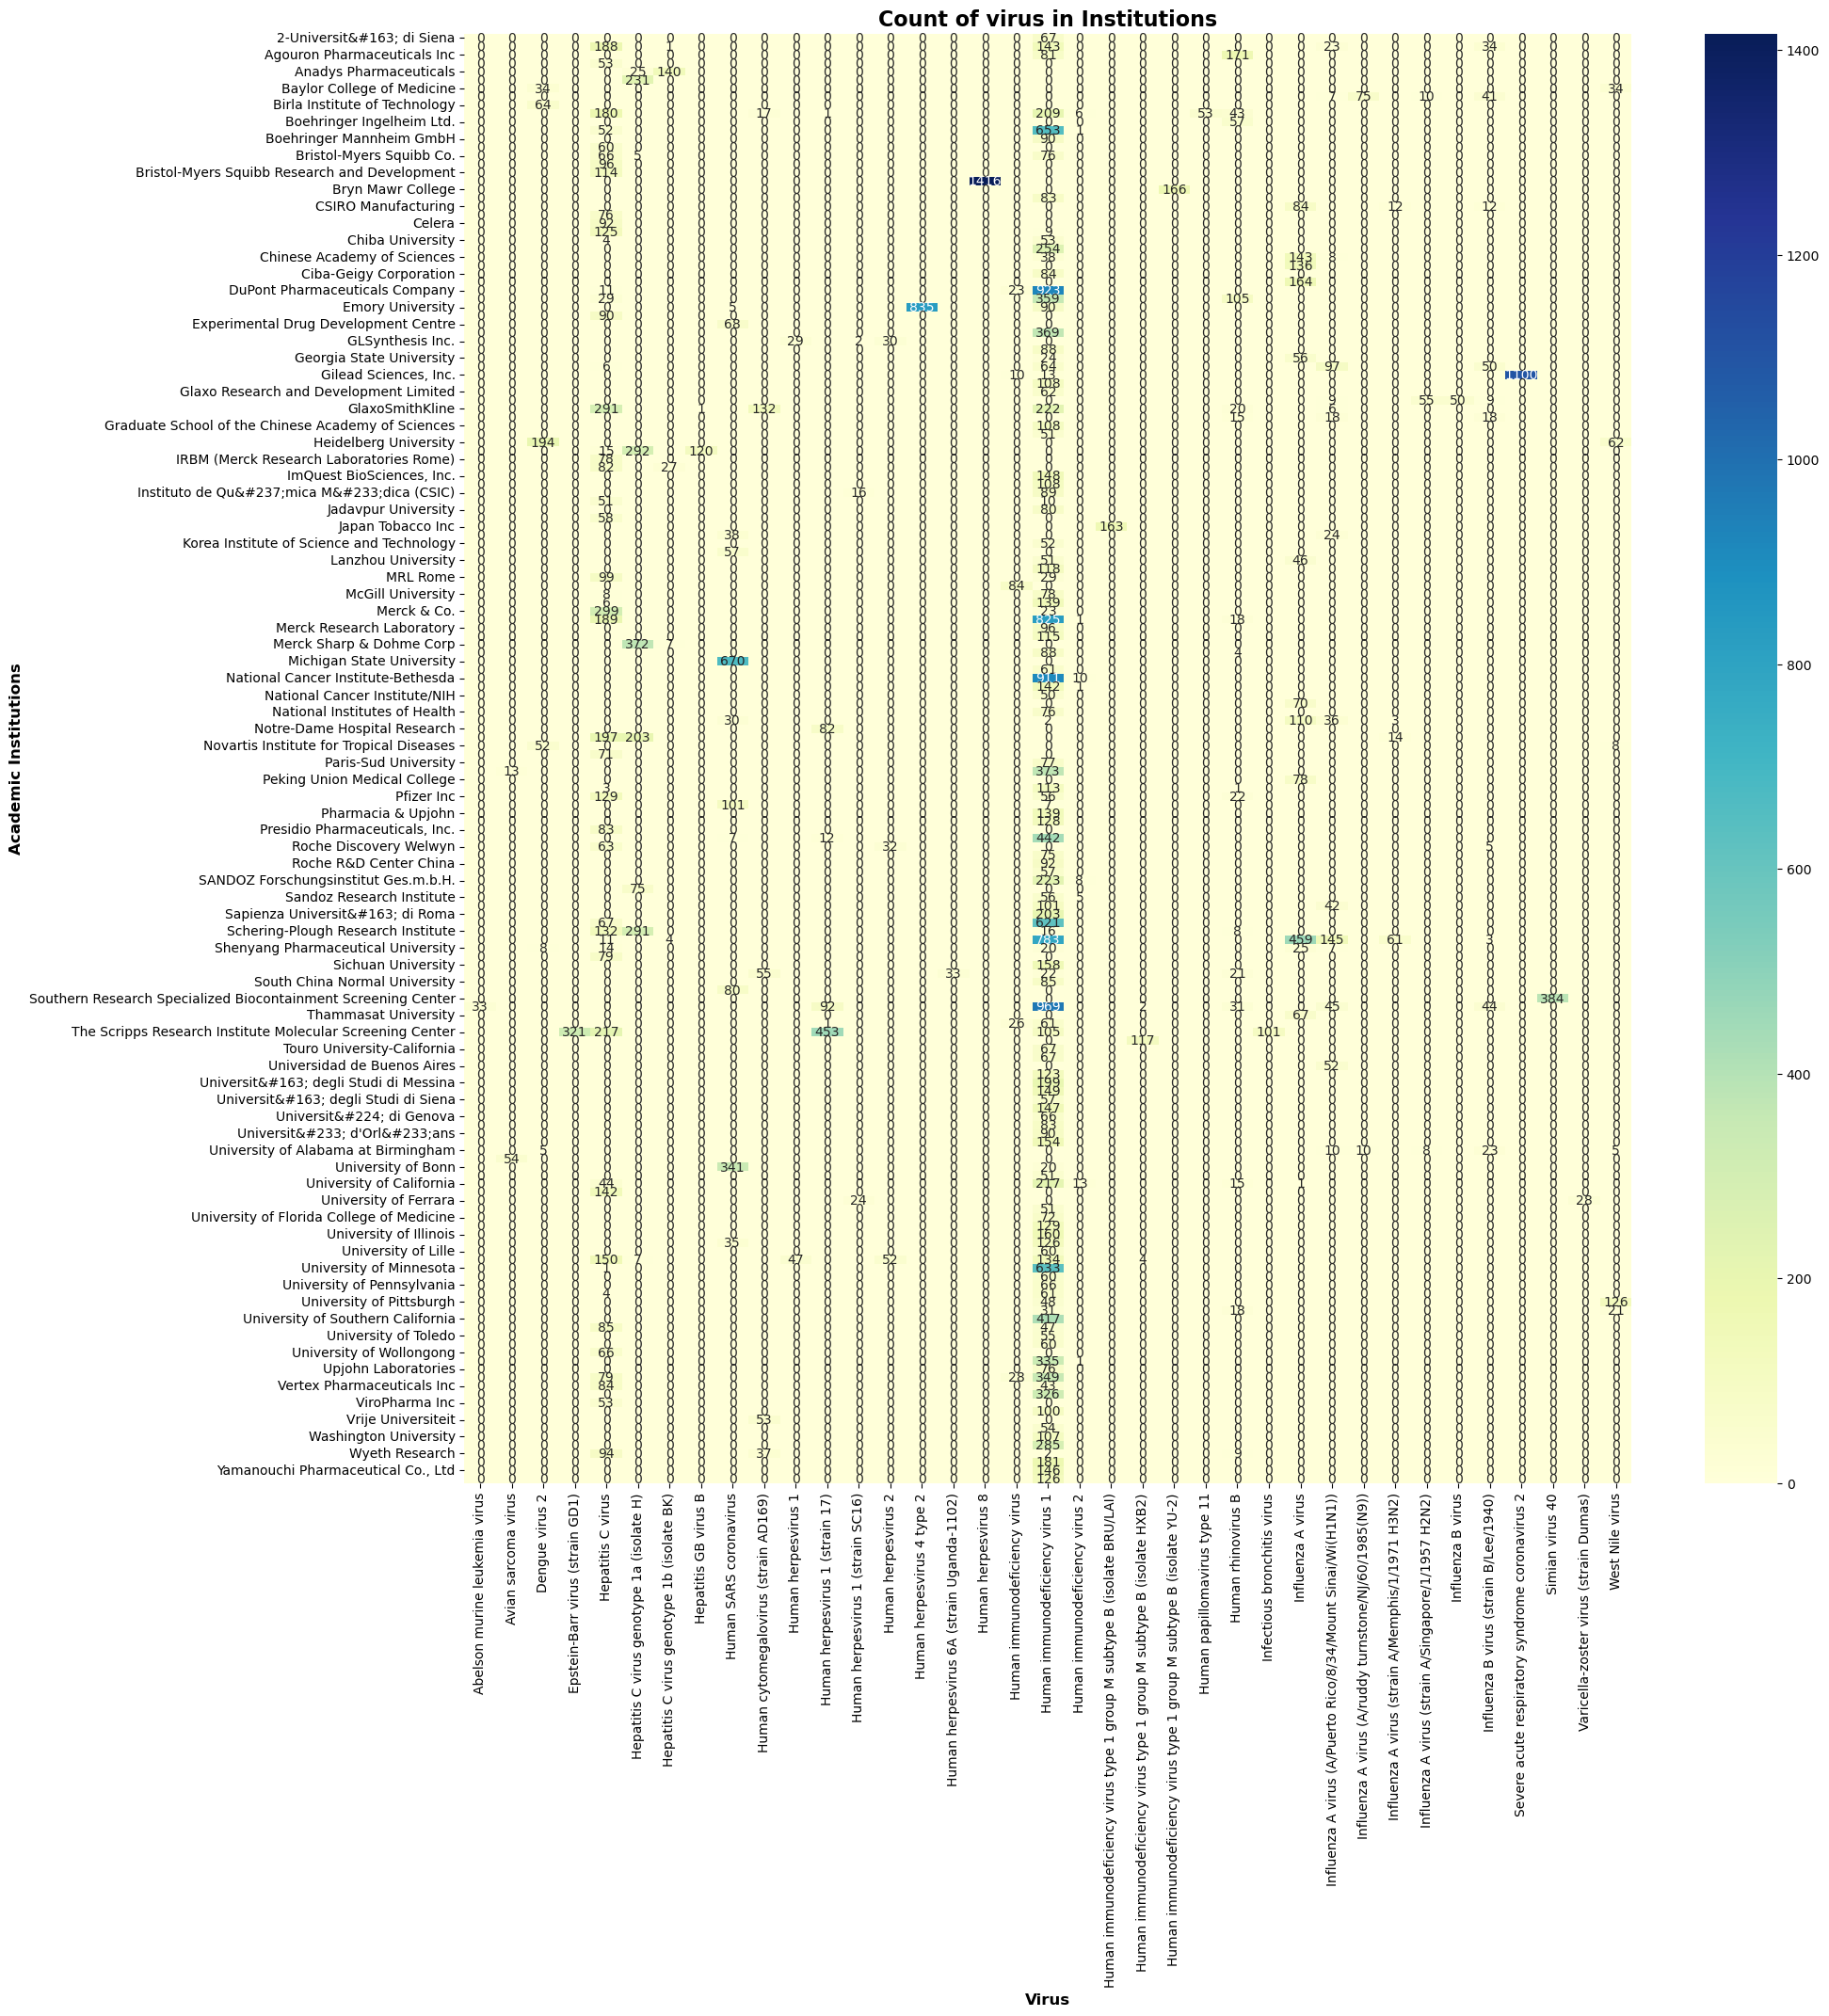

In [5]:
virus_data = data[data['Target Source Organism According to Curator or DataSource'].str.contains('virus', case=False, na=False)]

print(f'total number of virus associated protein: {virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()}')

virus_counts = pd.crosstab(virus_data['Institution'], 
                           virus_data['Target Source Organism According to Curator or DataSource'])

virus_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50] 
virus_counts = virus_counts[virus_counts.sum(axis=1) >= 50]

plt.figure(figsize=(20, 20))
sns.heatmap(virus_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of virus in Institutions', fontweight=800,fontsize=16)
plt.xlabel('Virus',fontweight=800,fontsize=12)
plt.ylabel('Academic Institutions', fontweight=800,fontsize=12)
plt.show()

Among all viruses, HIV-1 is the only one with sufficient Ki data and is extensively studied by numerous labs. In contrast, the available Kd data is too sparse to be useful.

In [6]:
non_nan_ki = virus_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (all viruses): ', non_nan_ki)

non_nan_kd = virus_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (all viruses): ', non_nan_kd)

Numbers of data containing Ki information (all viruses):  6415
Numbers of data containing Kd information (all viruses):  406


In [7]:
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)

non_nan_ki = hiv_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (Hiv1): ', non_nan_ki)

non_nan_kd = hiv_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (Hiv1): ', non_nan_kd)

Numbers of data containing Ki information (Hiv1):  4350
Numbers of data containing Kd information (Hiv1):  237


# <b><u> Focusing on HIV-1 </u></b> #

<b> Here we check if HIV-1 data is sufficient and viable to train a machine learning model. </b>

Some data rows contain Ki values like '<100' or '>30000', which are difficult to interpret. Therefore, we choose to drop these rows.

In [8]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


Let's check the distribution of Ki. Ideally, it should be diverse to train a machine learning model.

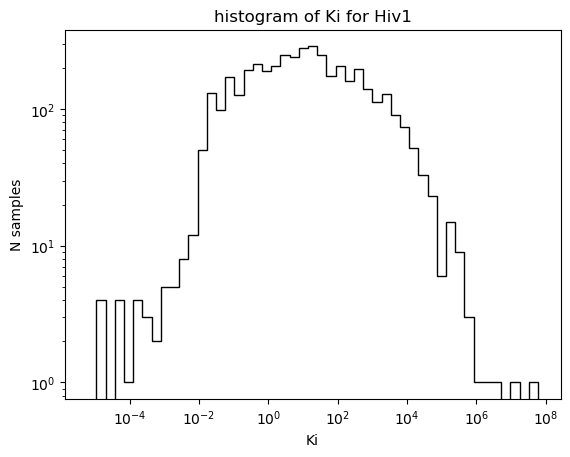

In [9]:
metric_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(metric_numeric.min()), np.log10(metric_numeric.max()), 50)
plt.hist(metric_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('histogram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

The data contains duplicate ligands and targets. For the machine learning model, it would be best to start by training on a single abundant unique target to refine the model and then gradually incorporate the complexity of multitarget learning. Additionally, it is important to ensure diversity among the proteins, as we would like the model to generalize better.

Number of Ligand compounds in HIV1:  5638


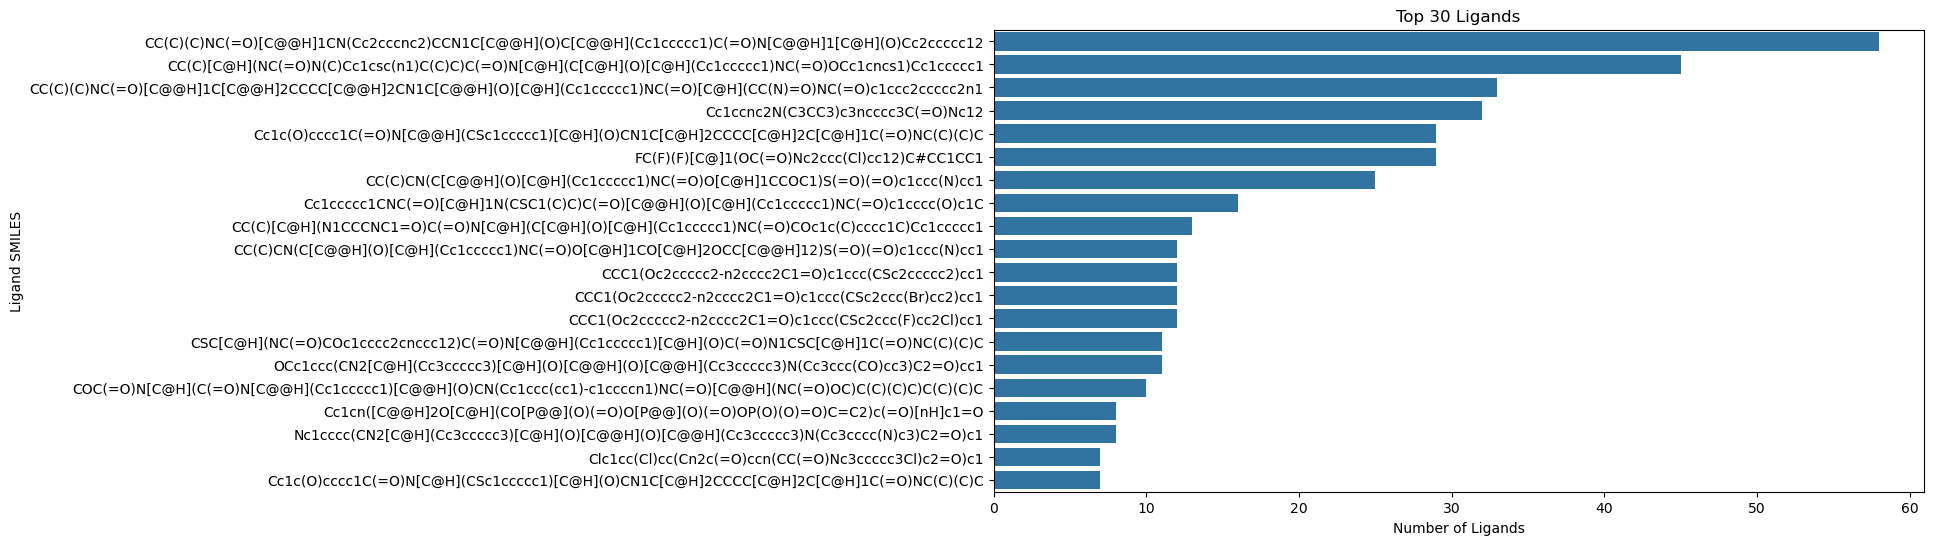

In [10]:
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of Ligand compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Ligands')
plt.xlabel('Number of Ligands')
plt.ylabel('Ligand SMILES')
plt.show()

Number of targets of the compounds in HIV1:  126


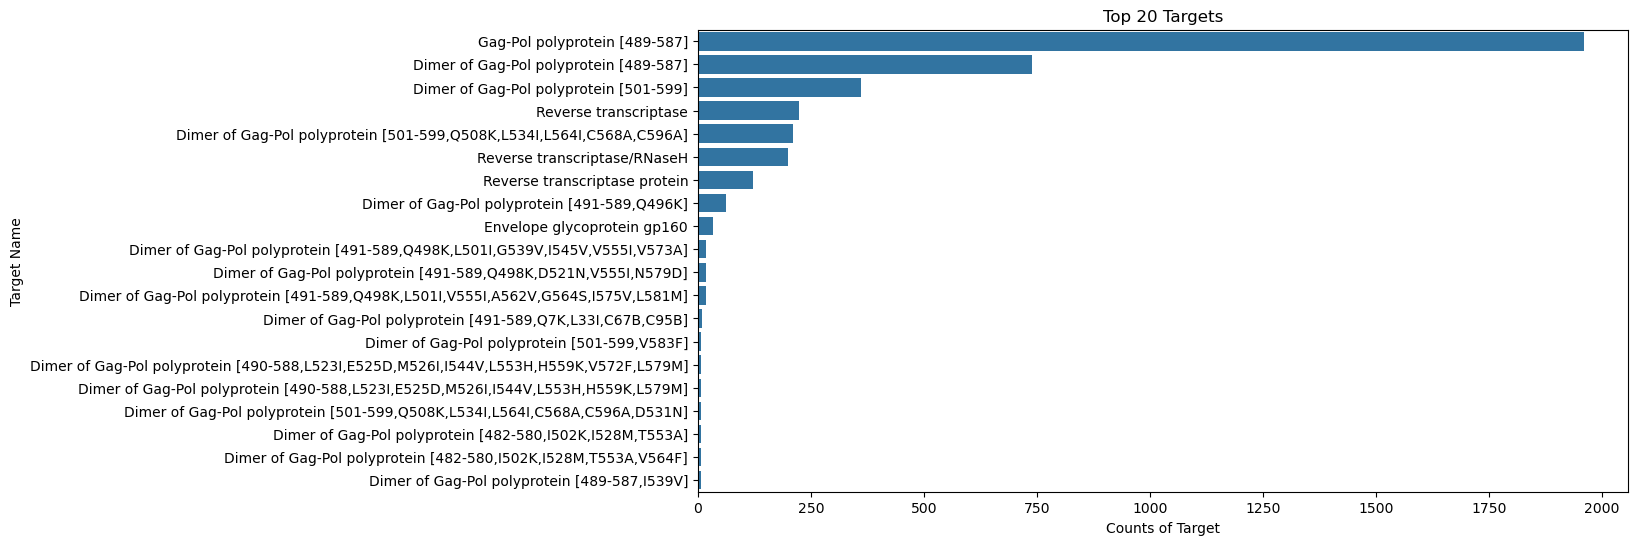

In [11]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets')
plt.xlabel('Counts of Target')
plt.ylabel('Target Name')
plt.show()

Some targets consist of multiple chains, which we need to account for in the machine learning model. We could either concatenate the chains of such targets and treat them as a single entity or handle them as separate parameters. This has not yet been decided.

In [12]:
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
seq_col = 'BindingDB Target Chain Sequence'

if col_name in hiv_data.columns and seq_col in hiv_data.columns:
    unique_data = hiv_data.drop_duplicates(subset=[seq_col])
    count_Nchain = unique_data[col_name].value_counts()

count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    56
2     7
Name: count, dtype: int64

# <u><b>CLUSTERING</b></u>

<b> To train a machine learning model, we must provide it with numerical data. For ligands, the only relevant information available is SMILES strings. Additionally, the data needs to be suitable for training, with data points that are differentiable.

To obtain continuous data, we first embed the SMILES using one of two algorithms: BERT embedding (using ChemBERTa) or Morgan Fingerprint.

Next, for visualisation purposes and due to computational constraints, we reduce the dimensionality of the data to three using two algorithms: t-SNE or UMAP. Both algorithms have their advantages and disadvantages. (We initially tried out PCA but we were not getting any good results, hence we decided to try better suited algorithms, hence t-SNE and UMAP.)

To draw final conclusions, we perform k-means clustering on the four combinations (BERT+t-SNE, BERT+UMAP, Morgan Fingerprint+t-SNE, Morgan Fingerprint+UMAP). We visually and numerically evaluate the best clusters with scores (silhouette score, Kullback-Leibler divergence for t-SNE, trustworthiness score for UMAP and normalized entropy). Clear, well-separated and balanced clusters are preferred. </b>

## <b>Clustering with Morgan Fingerprints: </b> ##

Advantages:

- The embedding is based on the environment of each atom (the surrounding atoms), providing a direct connection to the molecular structure.
- Produces a fixed vector size for each molecule, which can aid in clustering.
- Well-established and widely tested.

Inconveniences:

- Captures either local or global structures, depending on the radius (a hyperparameter) of the atom environments.
- Better suited for classification tasks; however, dimensionality reduction can mitigate this limitation.
- Highly sensitive to the radius parameter. If the radius is too large or too small, it can result in either overly sparse clusters or clusters that are difficult to differentiate.

More info on Morgan Fingerprints can be found in the implementation of [RDKit](https://github.com/rdkit/rdkit), and our implementations.py file.

Note: for dimension reduction of Morgan Fingerprints, we will use jaccard metric as it is suited for binary vectors

In [13]:
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

### Using TSNE: Generate Fingerprints + Compute and Plot Scores ###

Here and for each of subsequent combinations, we will evaluate the best number of clusters for k-means based on elbow method and silhouette score.

Radius = 2
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 4
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 5
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


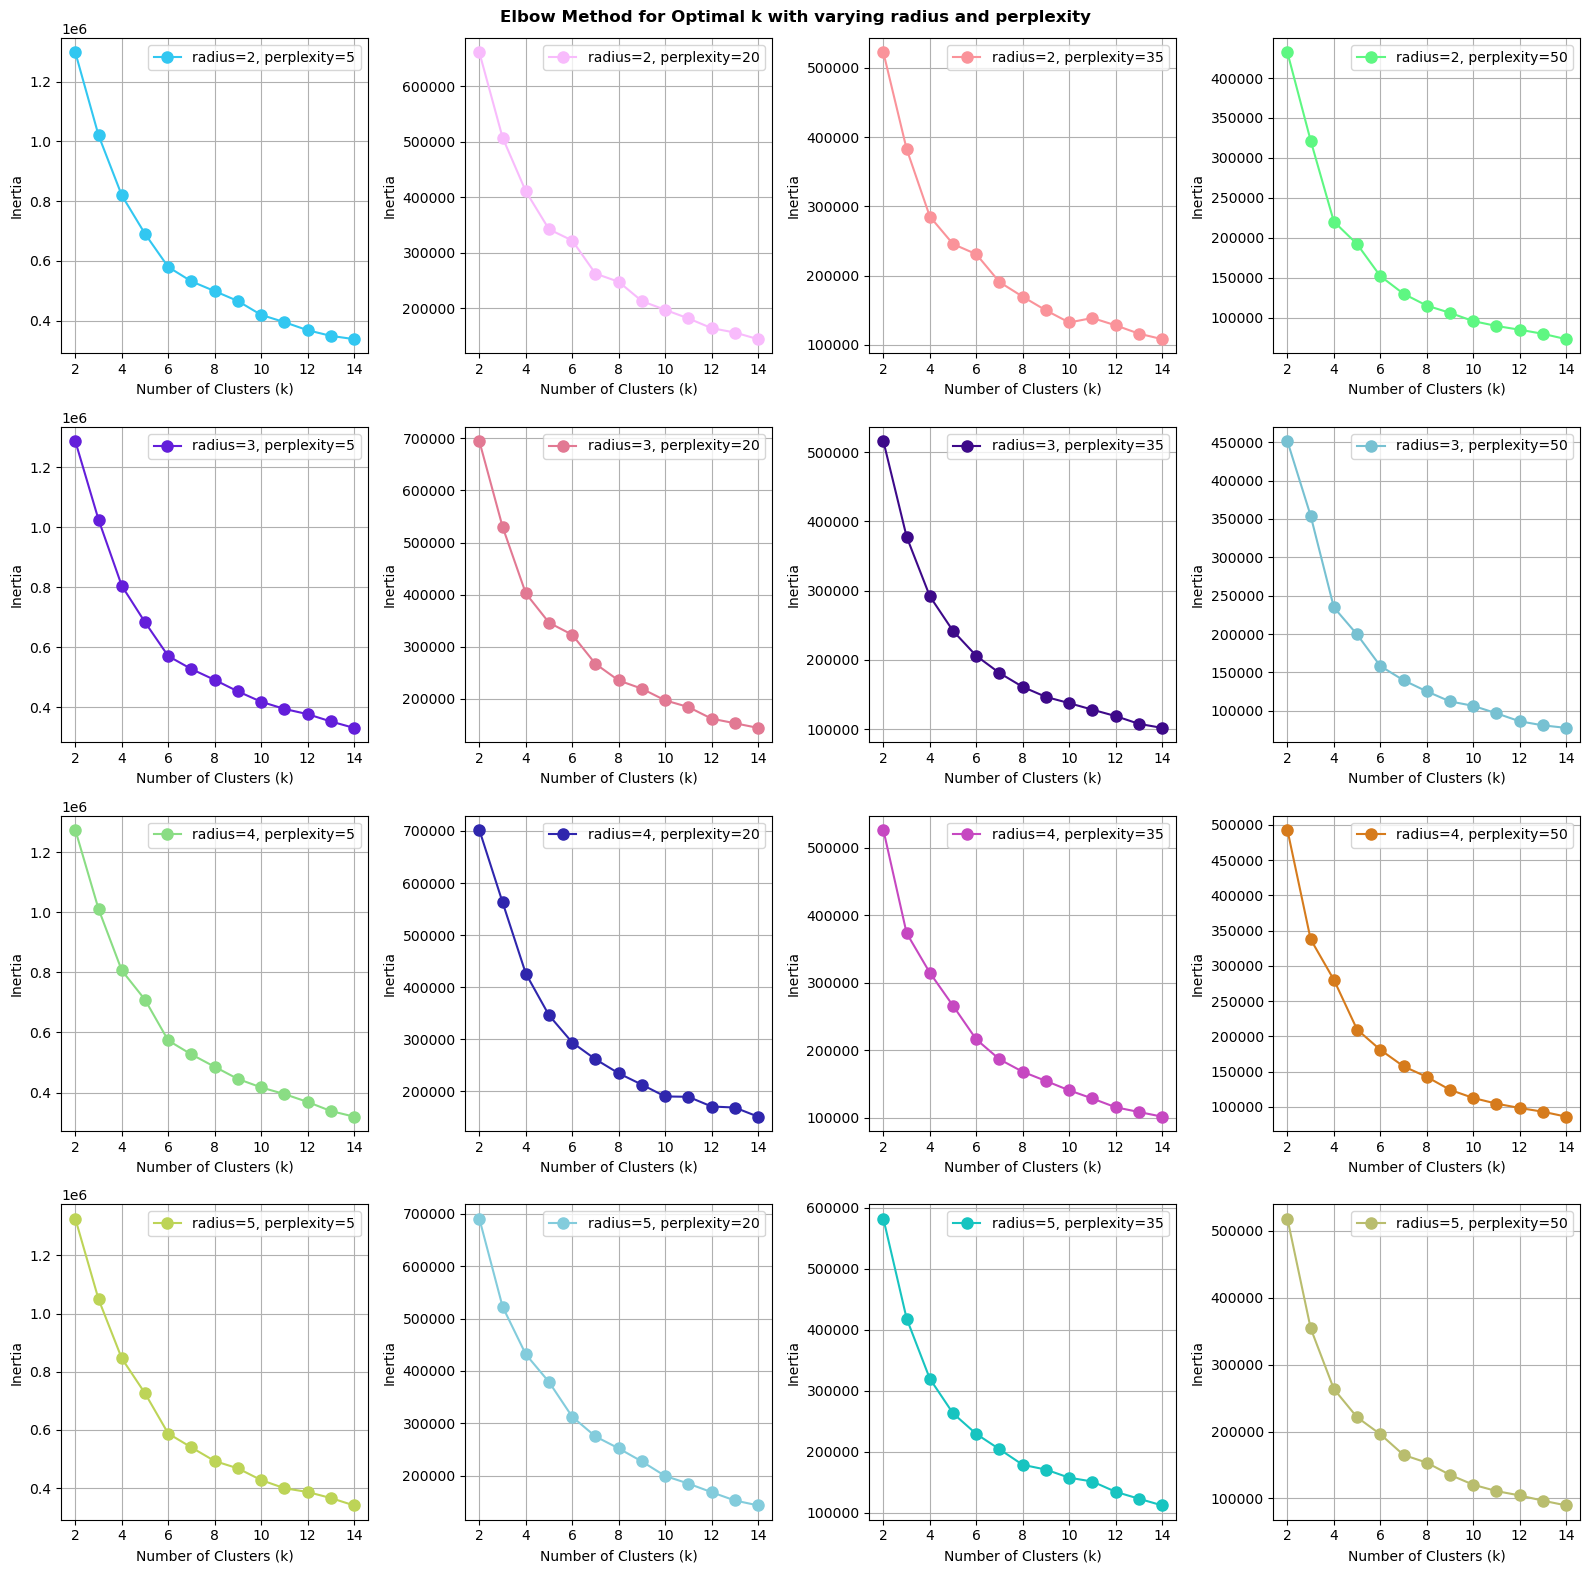

In [14]:
# For t-SNE, an important parameter to tune is perplexity (effective number of neighbors).
# We also tune the radius for Morgan Fingerprints

radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsn_results, KLs, s_scores = plot_elbow_curve(
    method='tsne',
    original_data=smiles_list,
    param1_list=radiuses,
    param2_list=perplexities,
    Ks=Ks,
    param1_name='radius',
    param2_name='perplexity',
    metric='jaccard',
    generate_MF=True
)

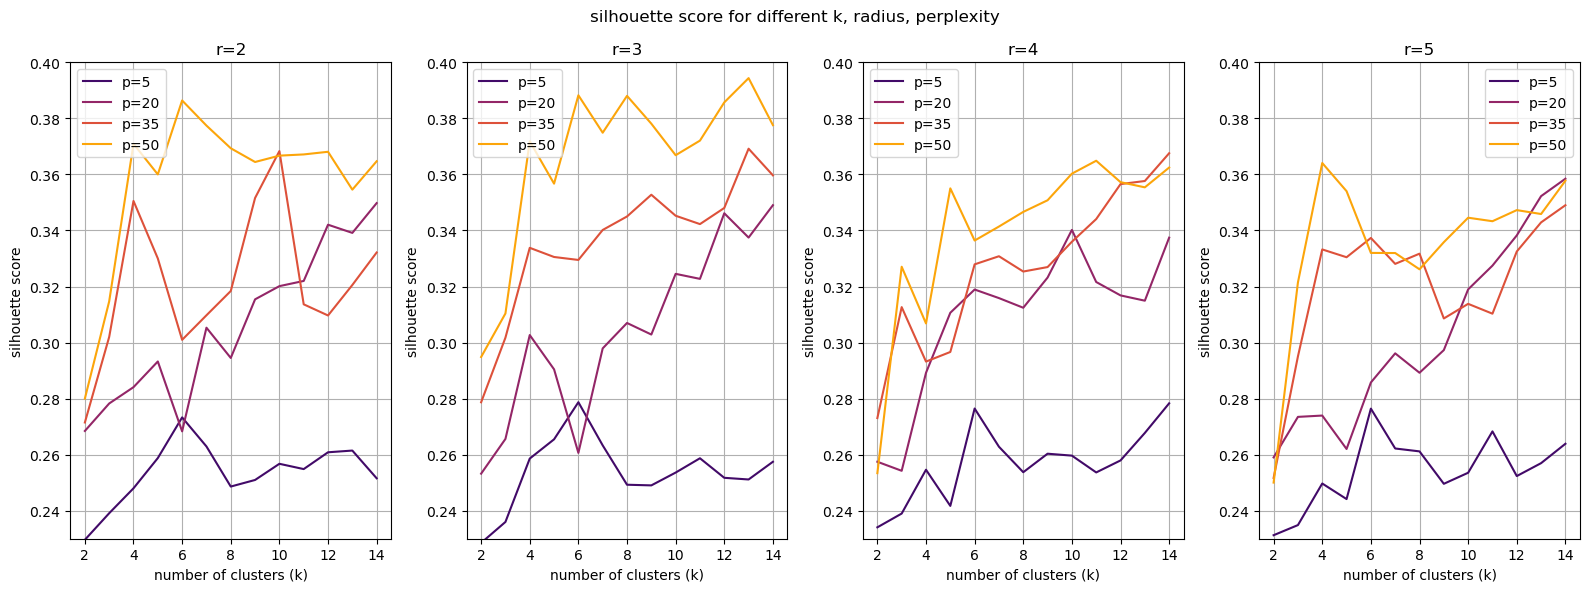

In [15]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.4),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

### Choosing best clusters from plots + Observing according distributions ###

Here, we first choose the best k for each combination manually and then plot the distribution of the clusters. The normalized entropy score is used to evaluate good distributions across the clusters (see implementations to have more info on this metric).

In [16]:
# Choose best k for each radius and perplexity based on the graphs (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,10,6],
           [6,12,9,6],
           [6,10,12,11],
           [6,12,6,4]]

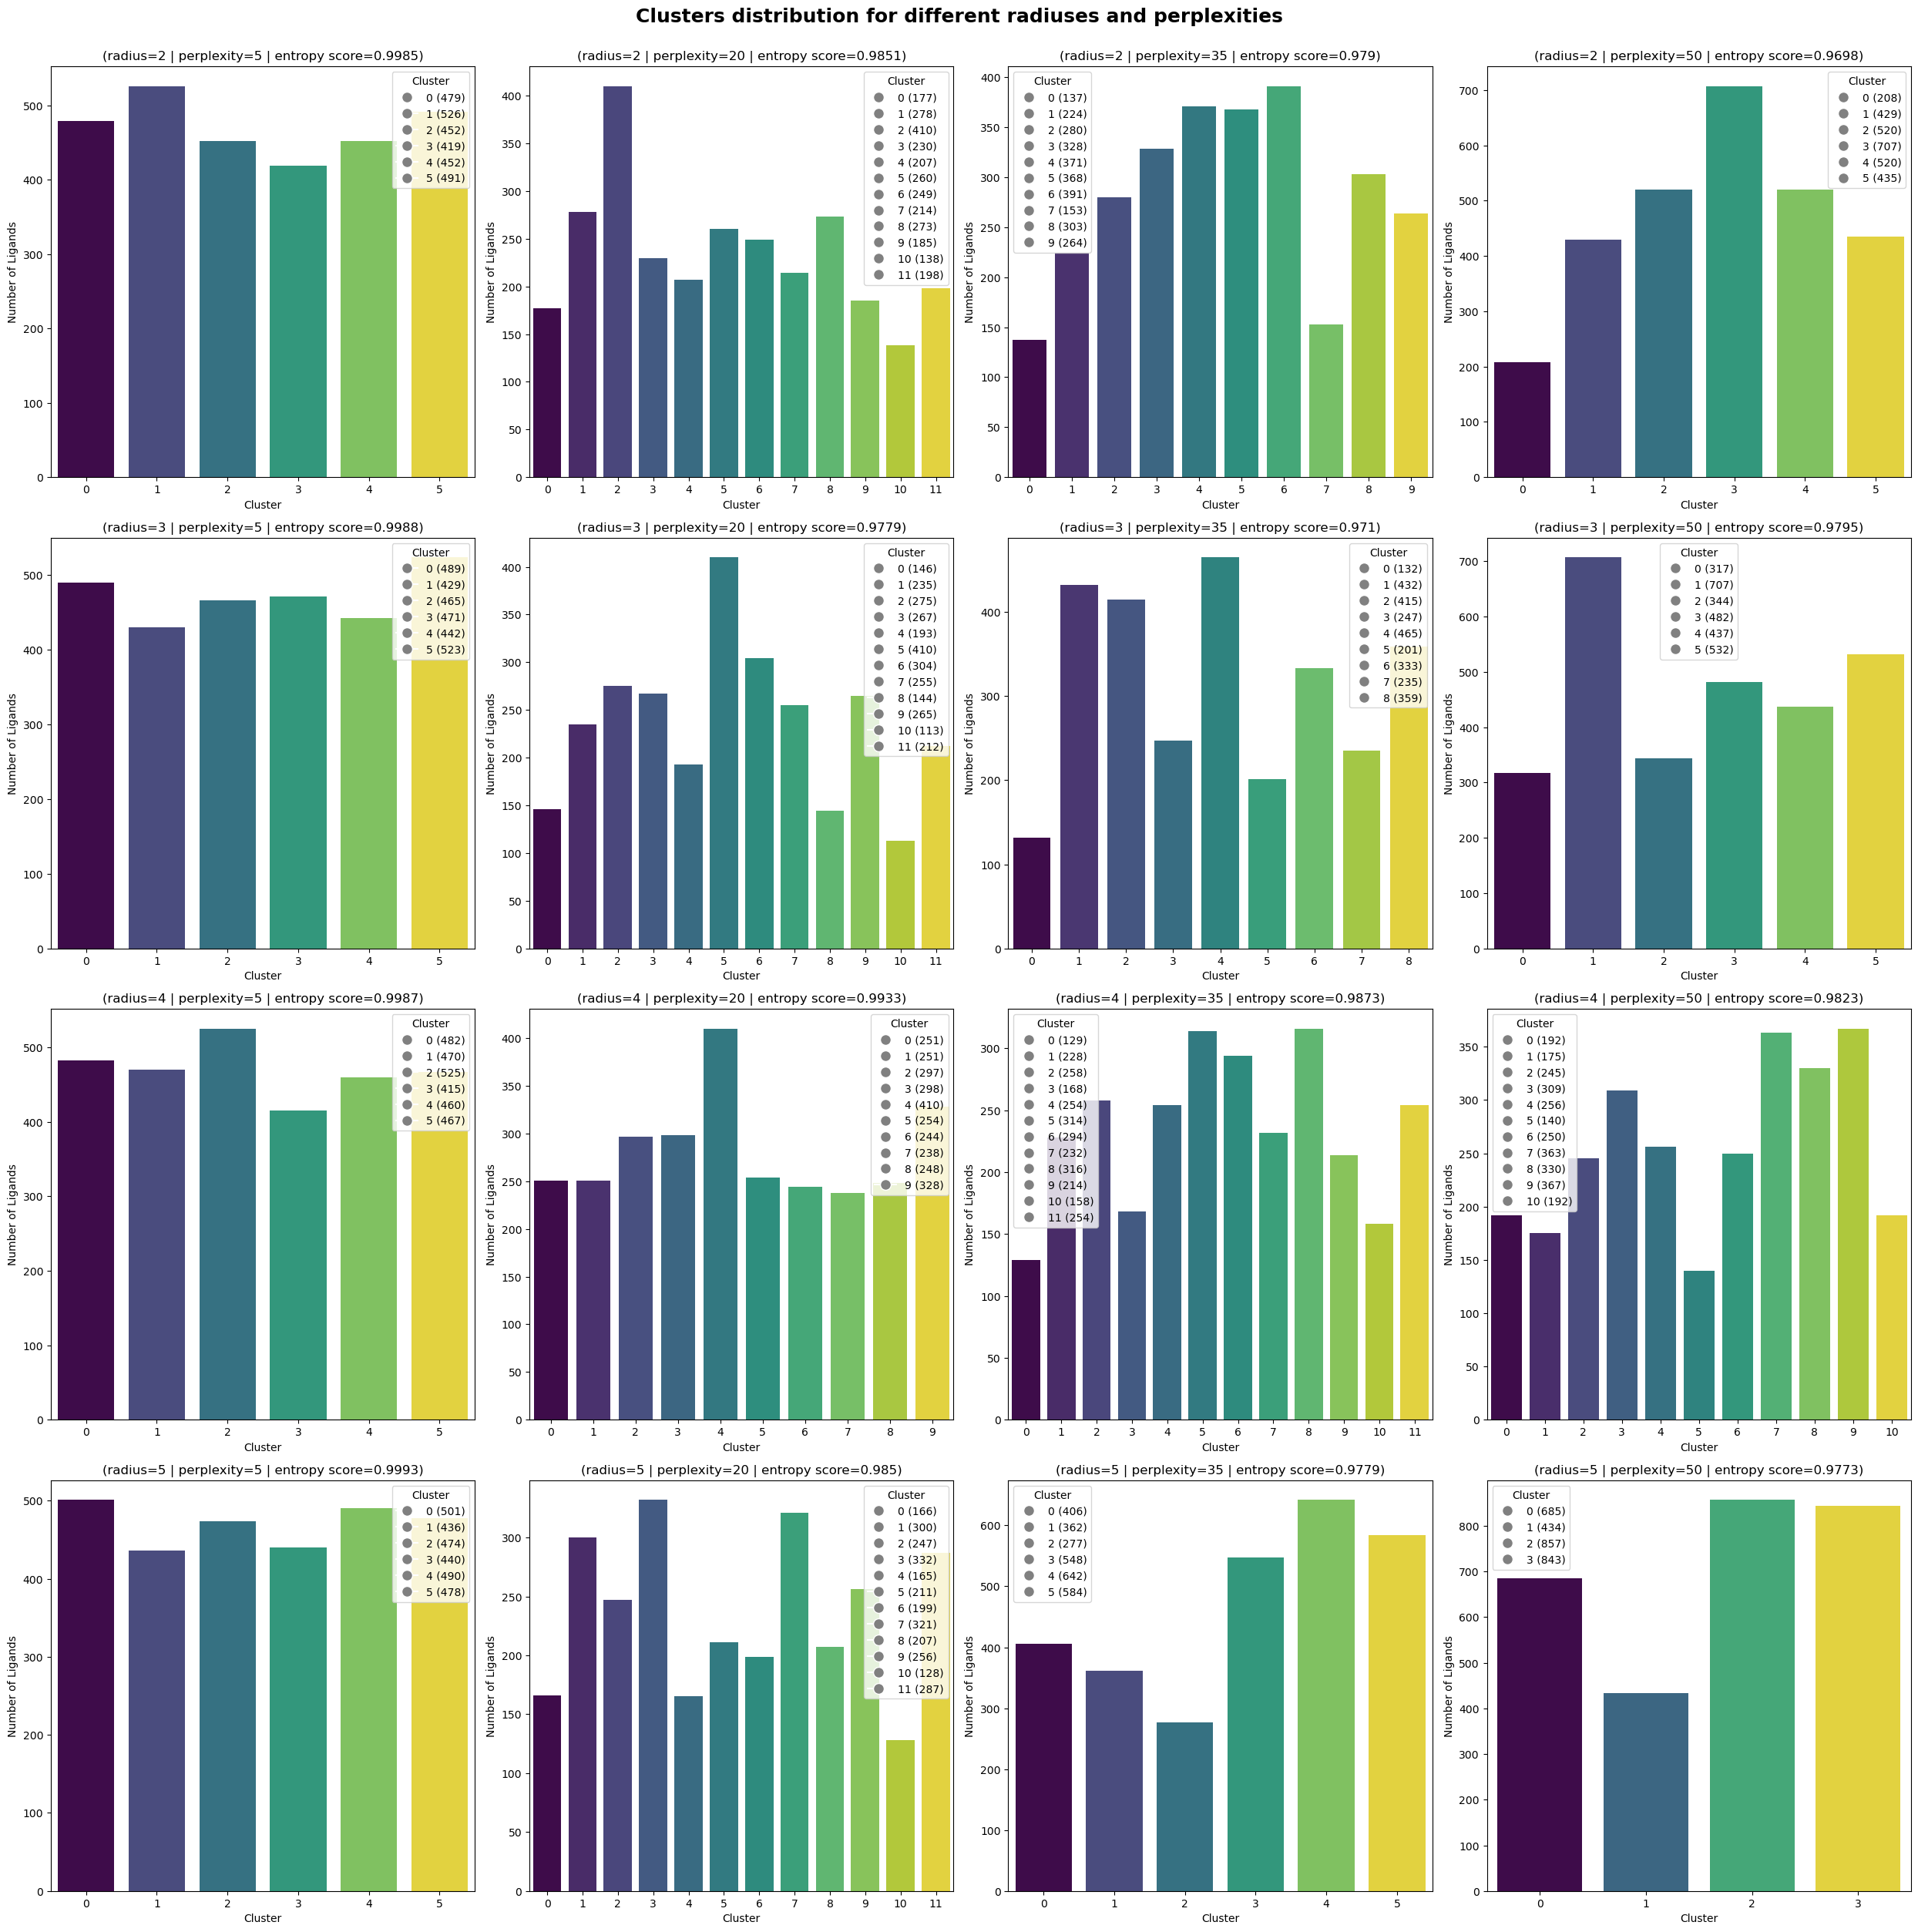

In [17]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities"
)

#### Choose best cluster according to KL metric and check them in reduced spatial representation ####

In [18]:
best_r = 0
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_r = radiuses[idx_r]
            best_p = perplexities[idx_p]

radius: 2 | perplexity: 5 | KL score: 0.552417516708374
radius: 2 | perplexity: 20 | KL score: 0.47736045718193054
radius: 2 | perplexity: 35 | KL score: 0.45127904415130615
radius: 2 | perplexity: 50 | KL score: 0.45064041018486023
radius: 3 | perplexity: 5 | KL score: 0.5536050200462341
radius: 3 | perplexity: 20 | KL score: 0.47465646266937256
radius: 3 | perplexity: 35 | KL score: 0.4576427936553955
radius: 3 | perplexity: 50 | KL score: 0.45243561267852783
radius: 4 | perplexity: 5 | KL score: 0.5375213623046875
radius: 4 | perplexity: 20 | KL score: 0.46273958683013916
radius: 4 | perplexity: 35 | KL score: 0.46268394589424133
radius: 4 | perplexity: 50 | KL score: 0.46262767910957336
radius: 5 | perplexity: 5 | KL score: 0.5201210975646973
radius: 5 | perplexity: 20 | KL score: 0.4685295820236206
radius: 5 | perplexity: 35 | KL score: 0.46512728929519653
radius: 5 | perplexity: 50 | KL score: 0.47749006748199463


In [19]:
MANUAL_INDEX = False

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[min_index[0]][min_index[1]]
    best_r = radiuses[min_index[0]]
    best_p = perplexities[min_index[1]]

k = best_ks[min_index[0]][min_index[1]]

In [20]:
print(f'Our best hyperparameters is: Radius of {best_r}, Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Radius of 2, Perplexity of 50 with KL Divergence of 0.45064041018486023


In [21]:
TSNE_MF_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using t-SNE dimension reduction](test/TSNE_MF.png)

### Using UMAP: Generate Fingerprints + Compute and Plot Scores ###

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


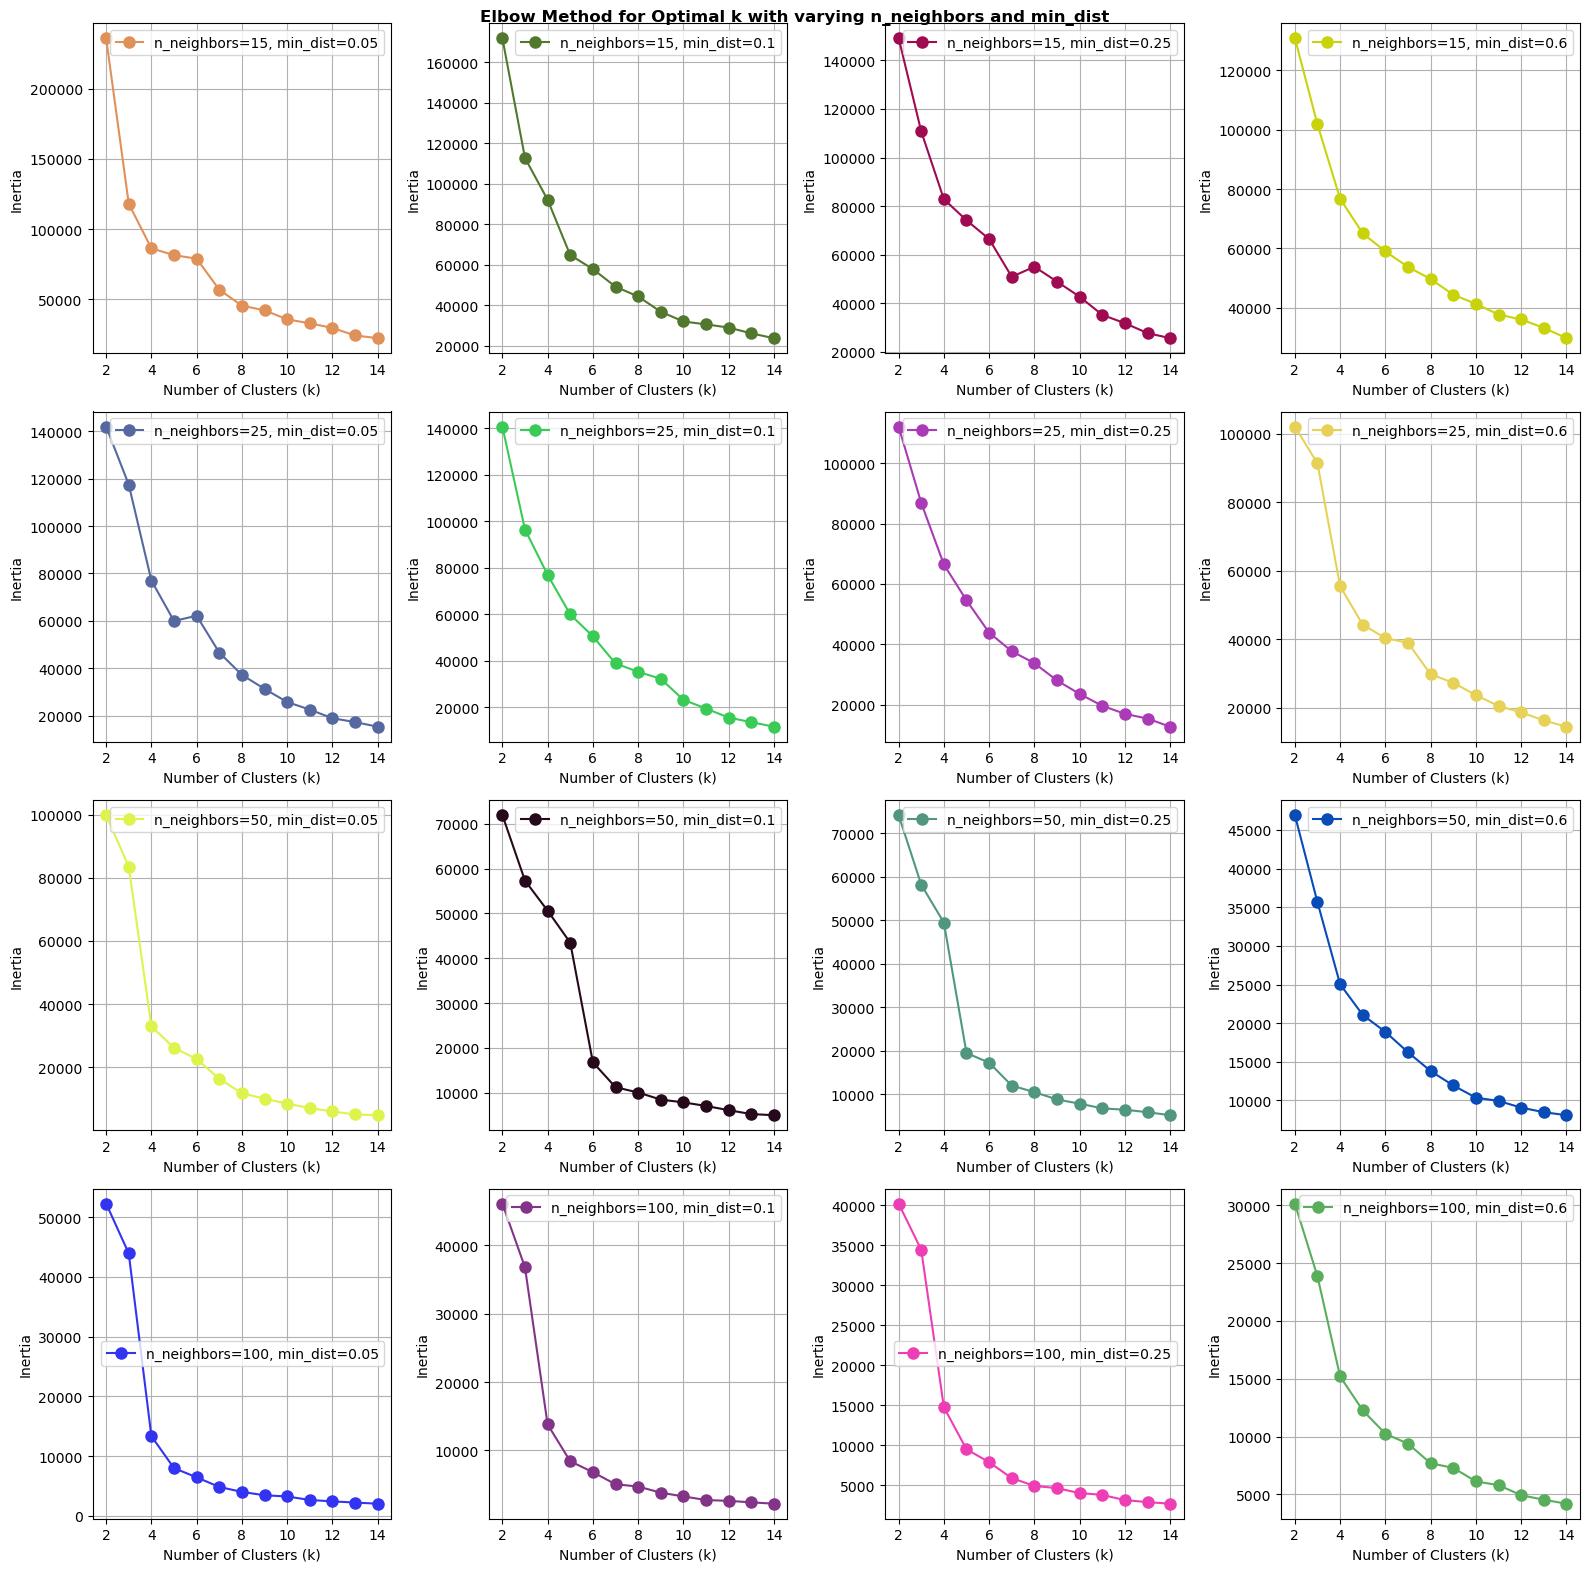

In [22]:
# Important parameters for UMAP are the minimum number of neighbors and the minimum distance between neighbors.
# We don't tune the radius for Morgan Fingerprints as this would clutter the analysis. Instead we take the one that performed best
# in t-SNE (default is put to 3 in the implementations)

l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
    method='umap',
    original_data=smiles_list,
    param1_list=l_n_neighbors,
    param2_list=min_dists,
    Ks=Ks,
    param1_name='n_neighbors',
    param2_name='min_dist',
    metric='jaccard',
    generate_MF=True
)

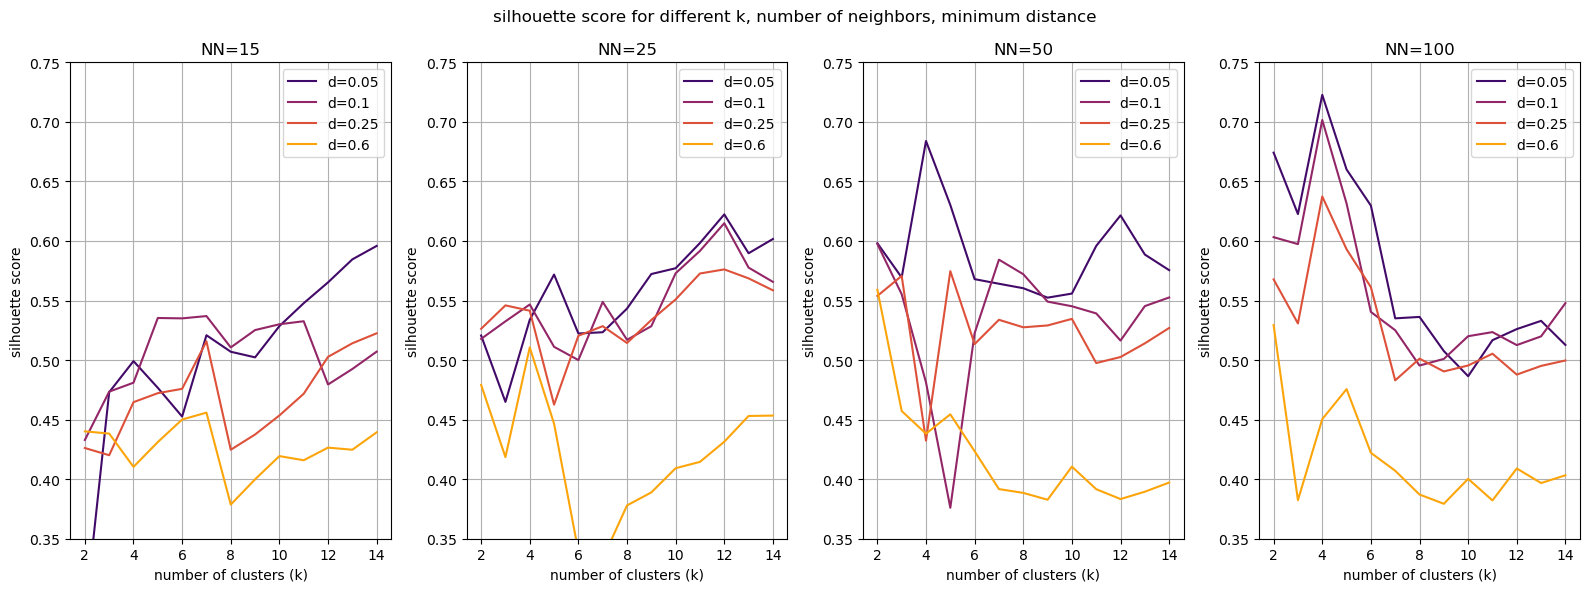

In [23]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.35, 0.75),
    color_palette="inferno", title="silhouette score for different k, number of neighbors, minimum distance"
)

In [24]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[7,6,5,11],
           [12,3,5,4],
           [4,4,4,2],
           [4,4,4,2]]

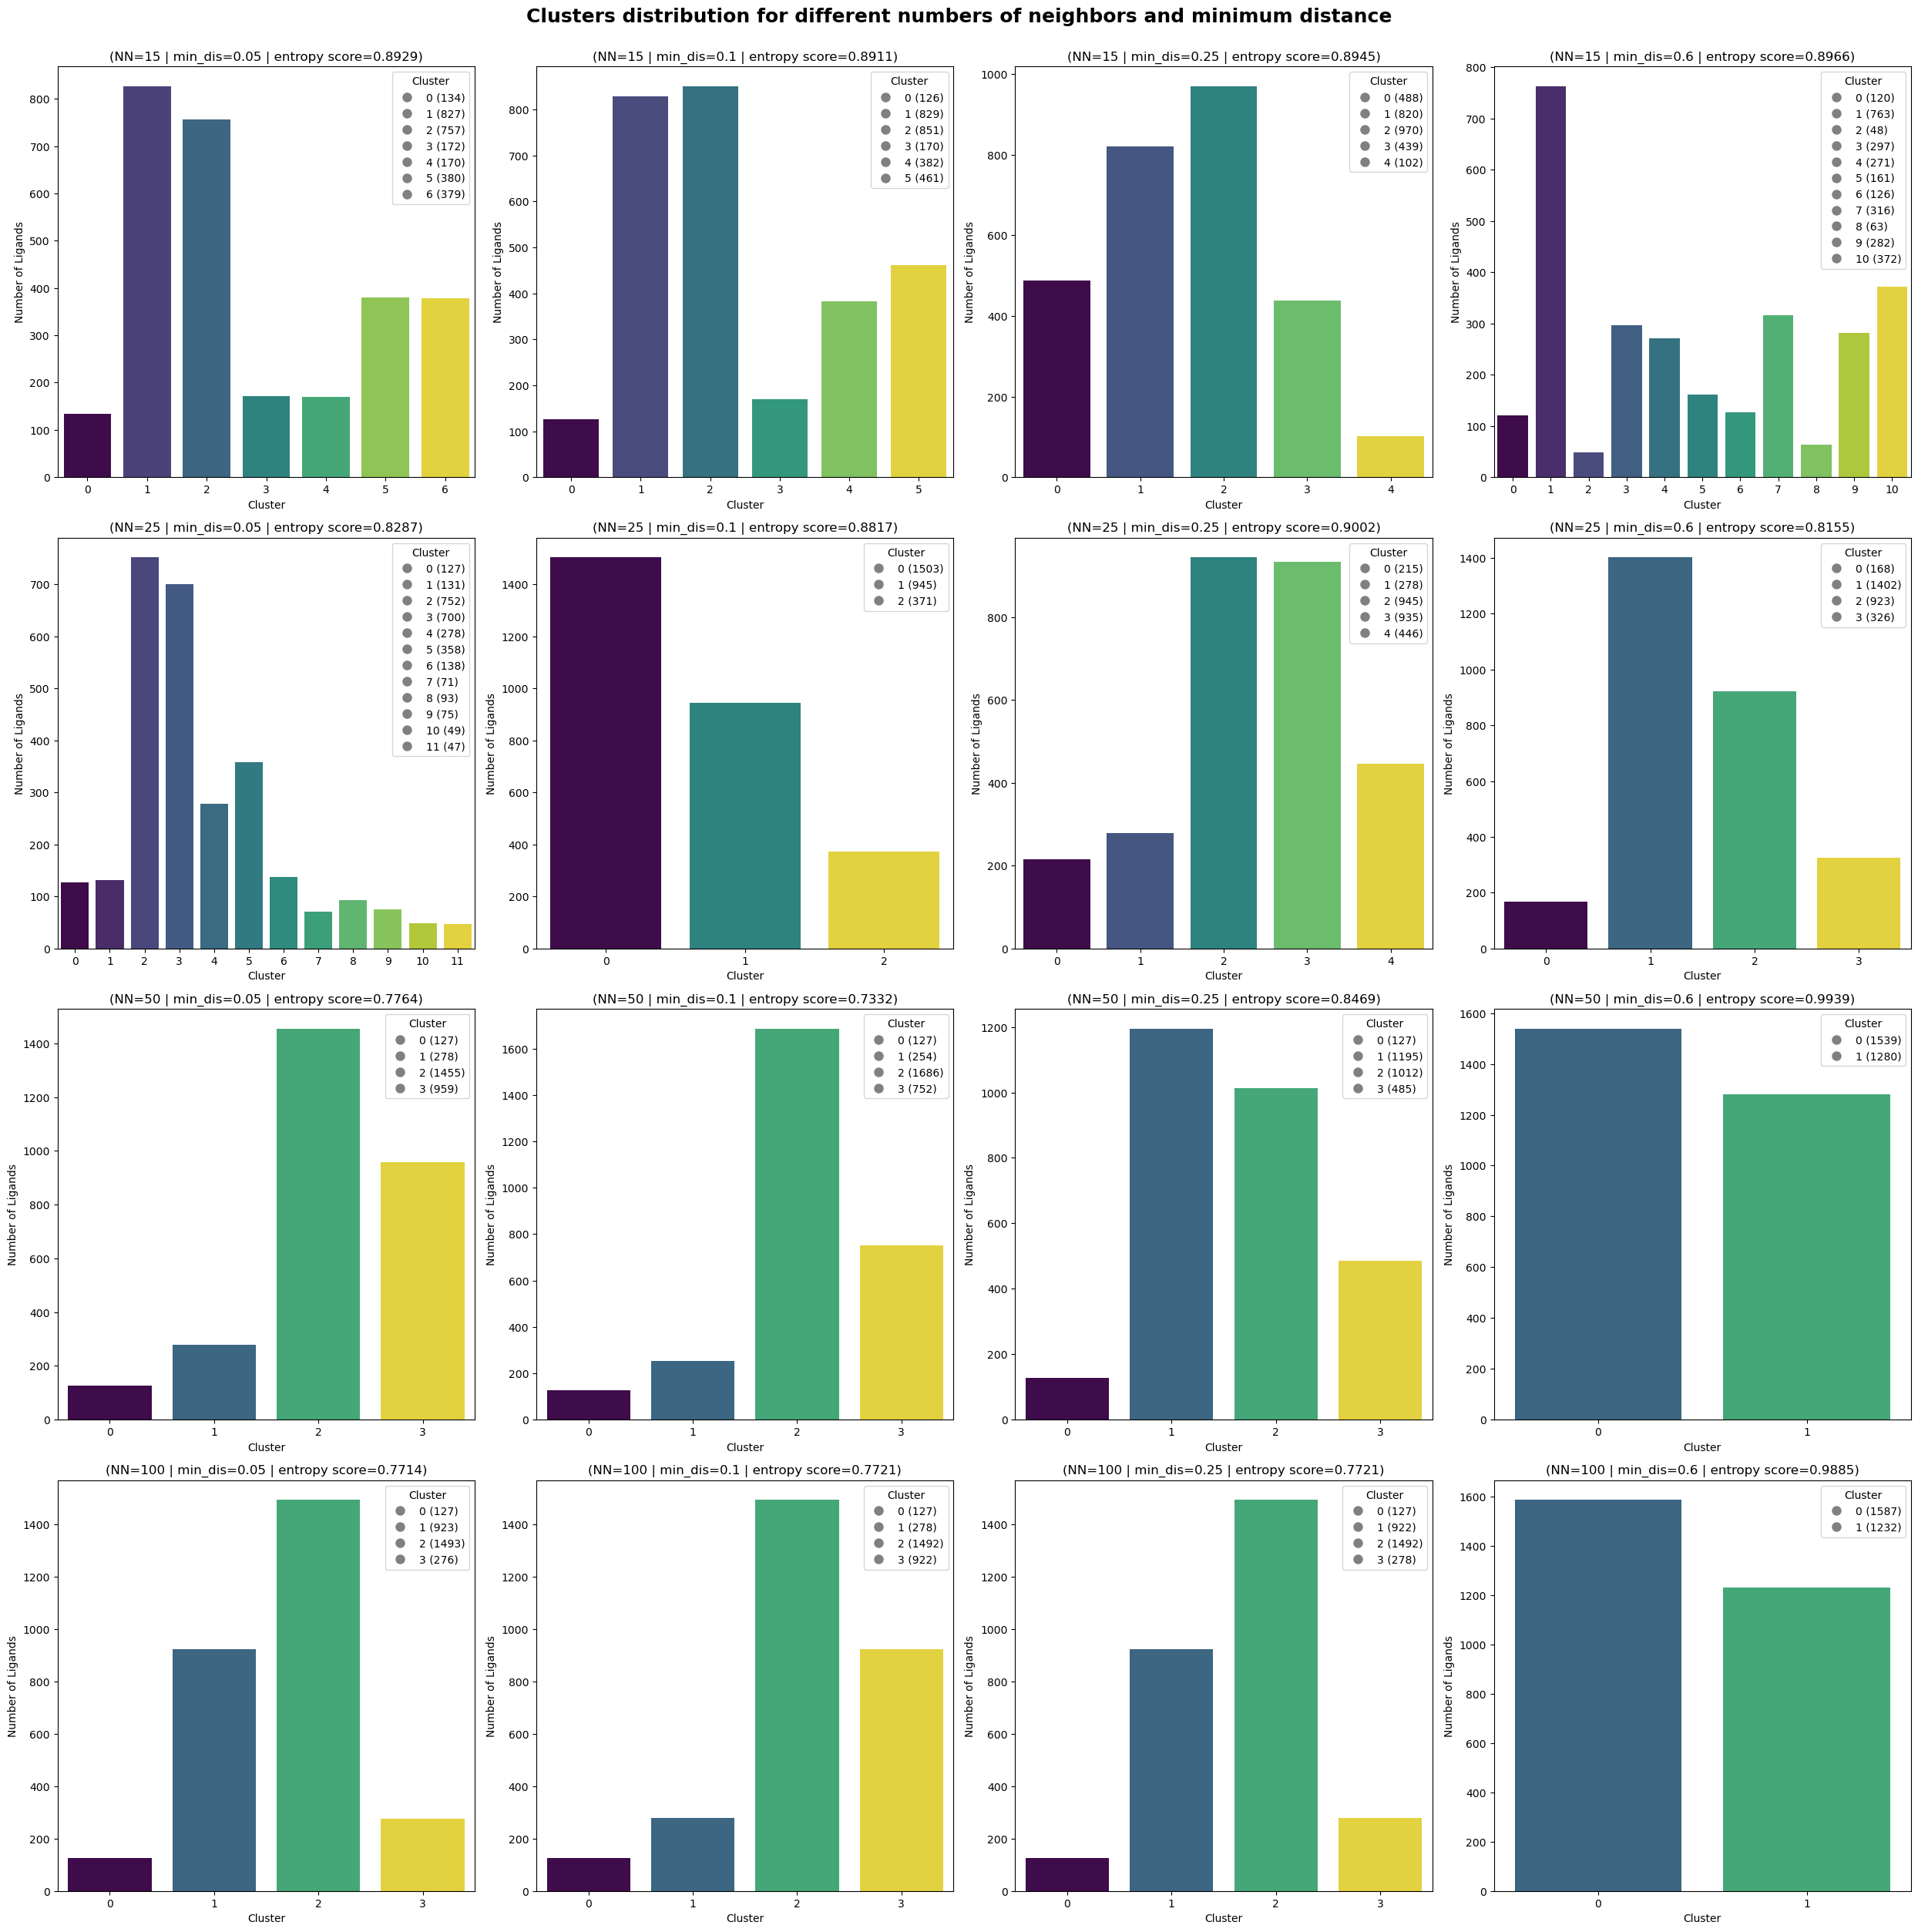

In [25]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_dis',
    title="Clusters distribution for different numbers of neighbors and minimum distance"
)

In [26]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9613068585791997
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.961883105360231
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9631957121129308
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9620085062141341
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9406472721511794
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9415212460675804
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9418114941261964
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9445475690908727
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.8959928724432538
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.8979569588617115
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.9001603053765768
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9021067345287028
number of n

In [27]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (3,1)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [28]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 100, Minimum Distance of 0.1 with Trust Score of 0.8417994612563388


In [29]:
UMAP_MF_df = plot_3d_clusters(umap_results, min_index, k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using UMAP dimension reduction](test/UMAP_MF.png)

## <b>Clustering with BERT Embeddings:</b> ##

Advantages:

- Effectively preserves both local and global structures.
- Suitable for various machine learning models.
- Captures complex relationships and dependencies, with a high number of features, making it highly effective for training complex models, provided overfitting is avoided.

Inconveniences:

- Computationally expensive.
- Difficult to interpret, unlike Morgan Fingerprints.

More info on BERT embedding can be found in the BERT [implementation](https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1), or our implemetations.py file.

Note: for dimension reduction of BERT embeddings, we will use cosine metric as it is suited for semantic relationships

#### Generating embeddings ####

In [30]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
model, tokenizer = get_BERT_model(model_name)

In [31]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 500 == 0:
    print(f'iteration {i}')
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500


#### Using TSNE to reduce dimensions ####

Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


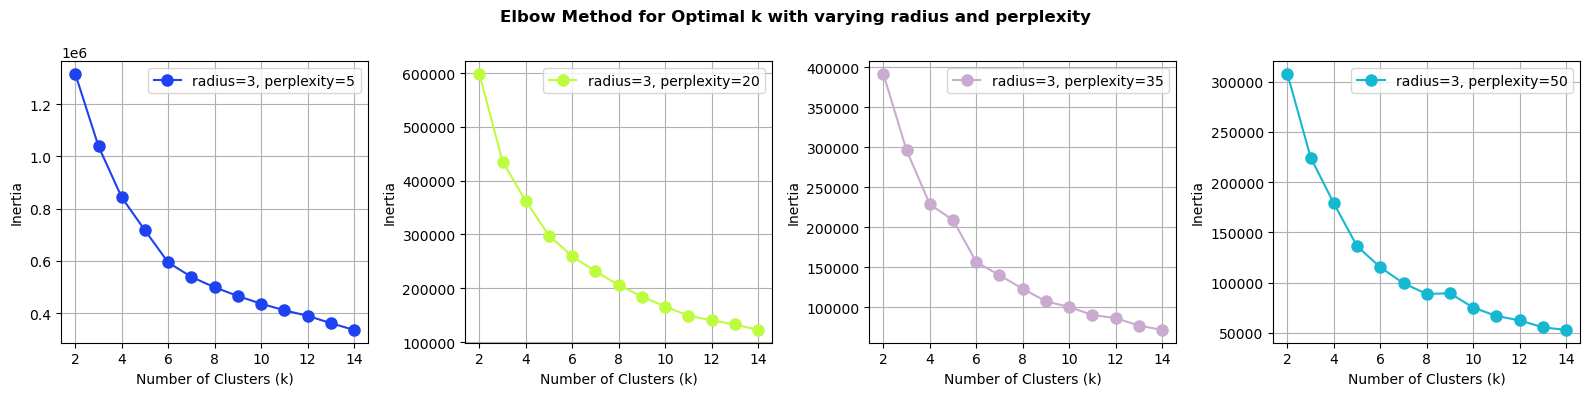

In [32]:
# We don't need radius here as we do not use Morgan Fingerprints, but for the implementation it is necessary to still pass the parameter
radiuses = [3]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsne_results, KLs, s_scores = plot_elbow_curve(
                                                method='tsne',
                                                original_data=embeddings,
                                                param1_list=radiuses,
                                                param2_list=perplexities,
                                                Ks=Ks,
                                                param1_name='radius',
                                                param2_name='perplexity',
                                                metric='cosine'
                                                        )

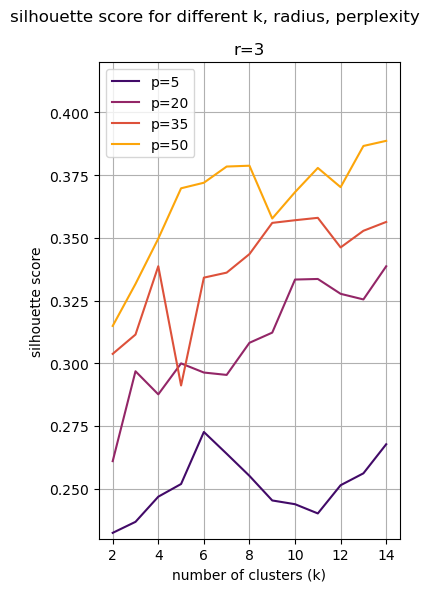

In [33]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.42),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

In [34]:
# Choose best k for each perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,10,11,8]]

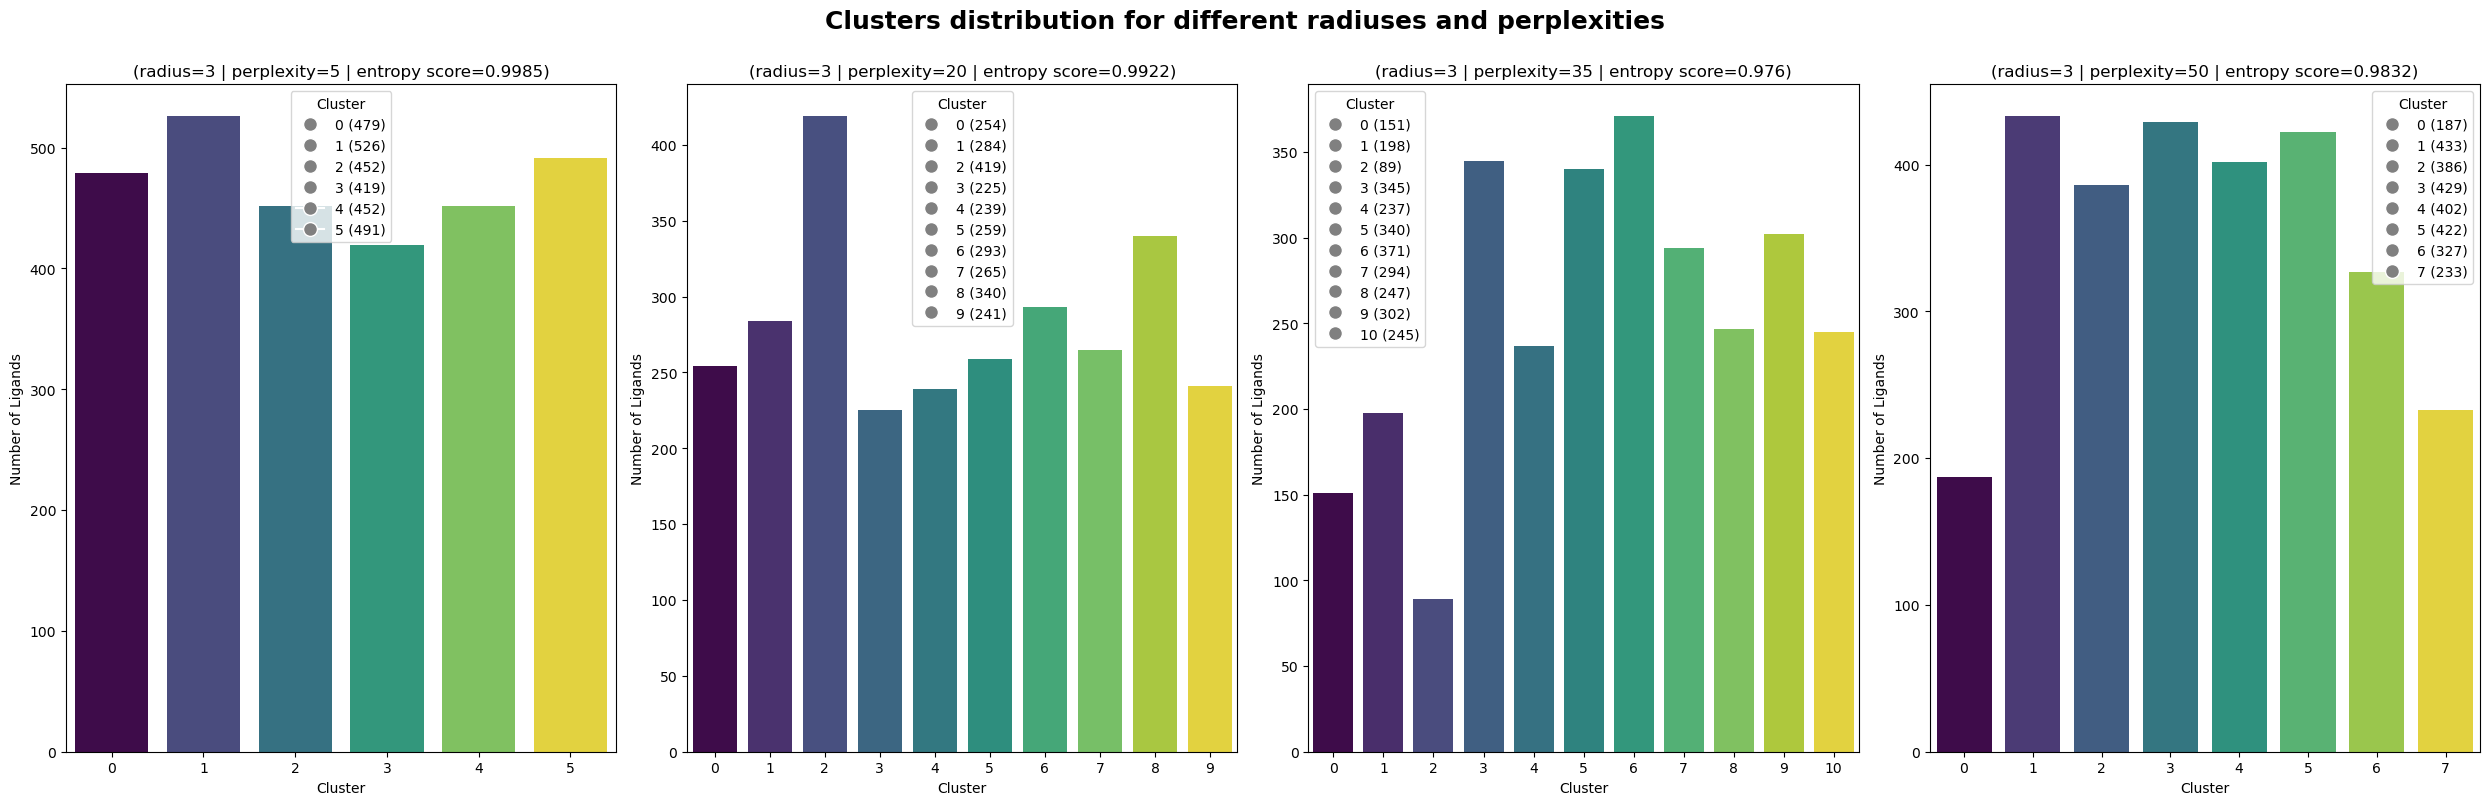

In [35]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities",
    figsize=(25,8)
)

In [36]:
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_p = perplexities[idx_p]

perplexity: 5 | KL score: 0.499663382768631
perplexity: 20 | KL score: 0.5889309048652649
perplexity: 35 | KL score: 0.613968014717102
perplexity: 50 | KL score: 0.6162129640579224


In [37]:
# use KL or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[idx_r][idx_p]
    best_p = perplexities[idx_p]

print(min_index)

(0, 3)


In [38]:
print(f'Our best hyperparameters is: Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Perplexity of 50 with KL Divergence of 0.6162129640579224


In [39]:
TSNE_BERT_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using t-SNE dimension reduction](test/TSNE_BERT.png)

#### Using UMAP to reduce dimensions ####

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


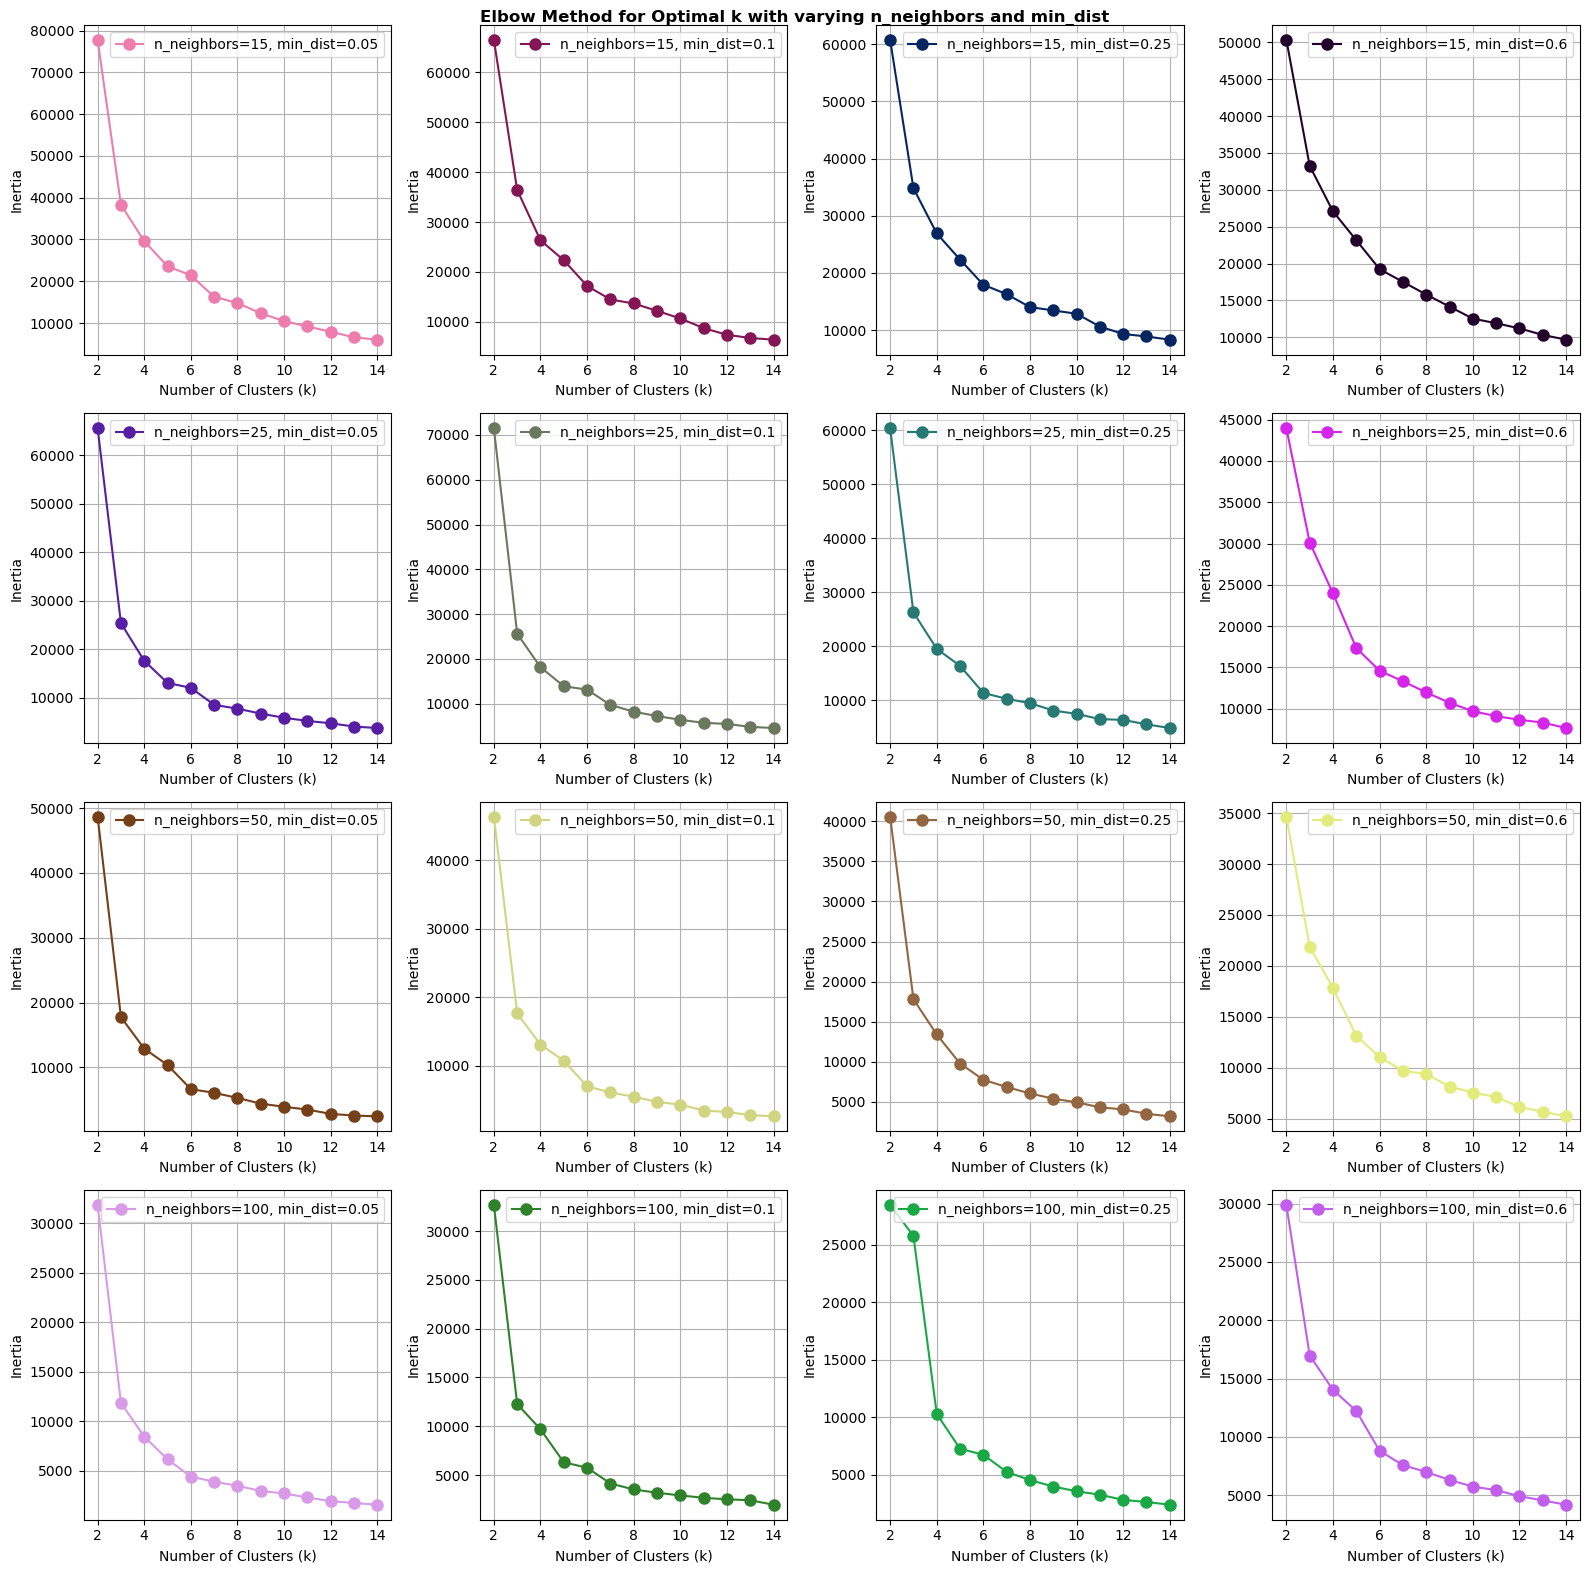

In [40]:
l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
                                        method='umap',
                                        original_data=embeddings,
                                        param1_list=l_n_neighbors,
                                        param2_list=min_dists,
                                        Ks=Ks,
                                        param1_name='n_neighbors',
                                        param2_name='min_dist',
                                        metric='cosine')

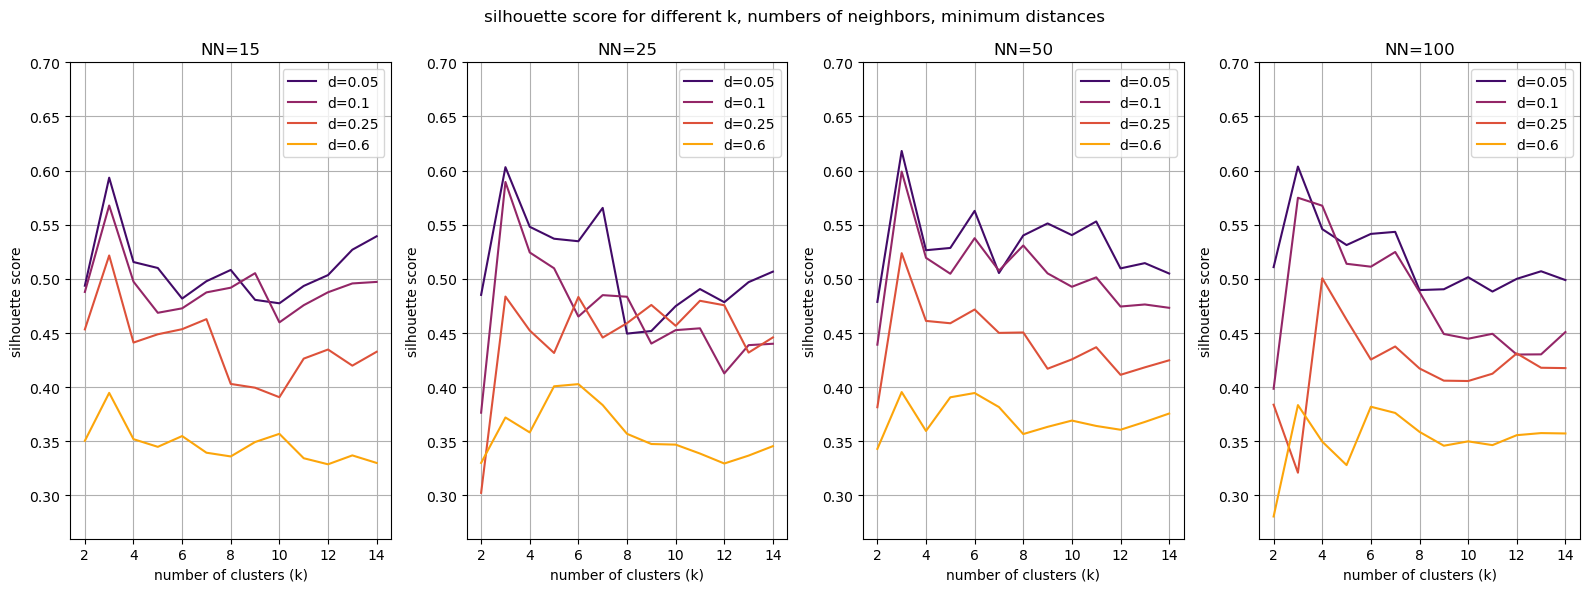

In [41]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.26, 0.7),
    color_palette="inferno", title="silhouette score for different k, numbers of neighbors, minimum distances"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[3,3,3,3],
           [3,3,3,6],
           [3,3,3,3],
           [3,3,4,3]]

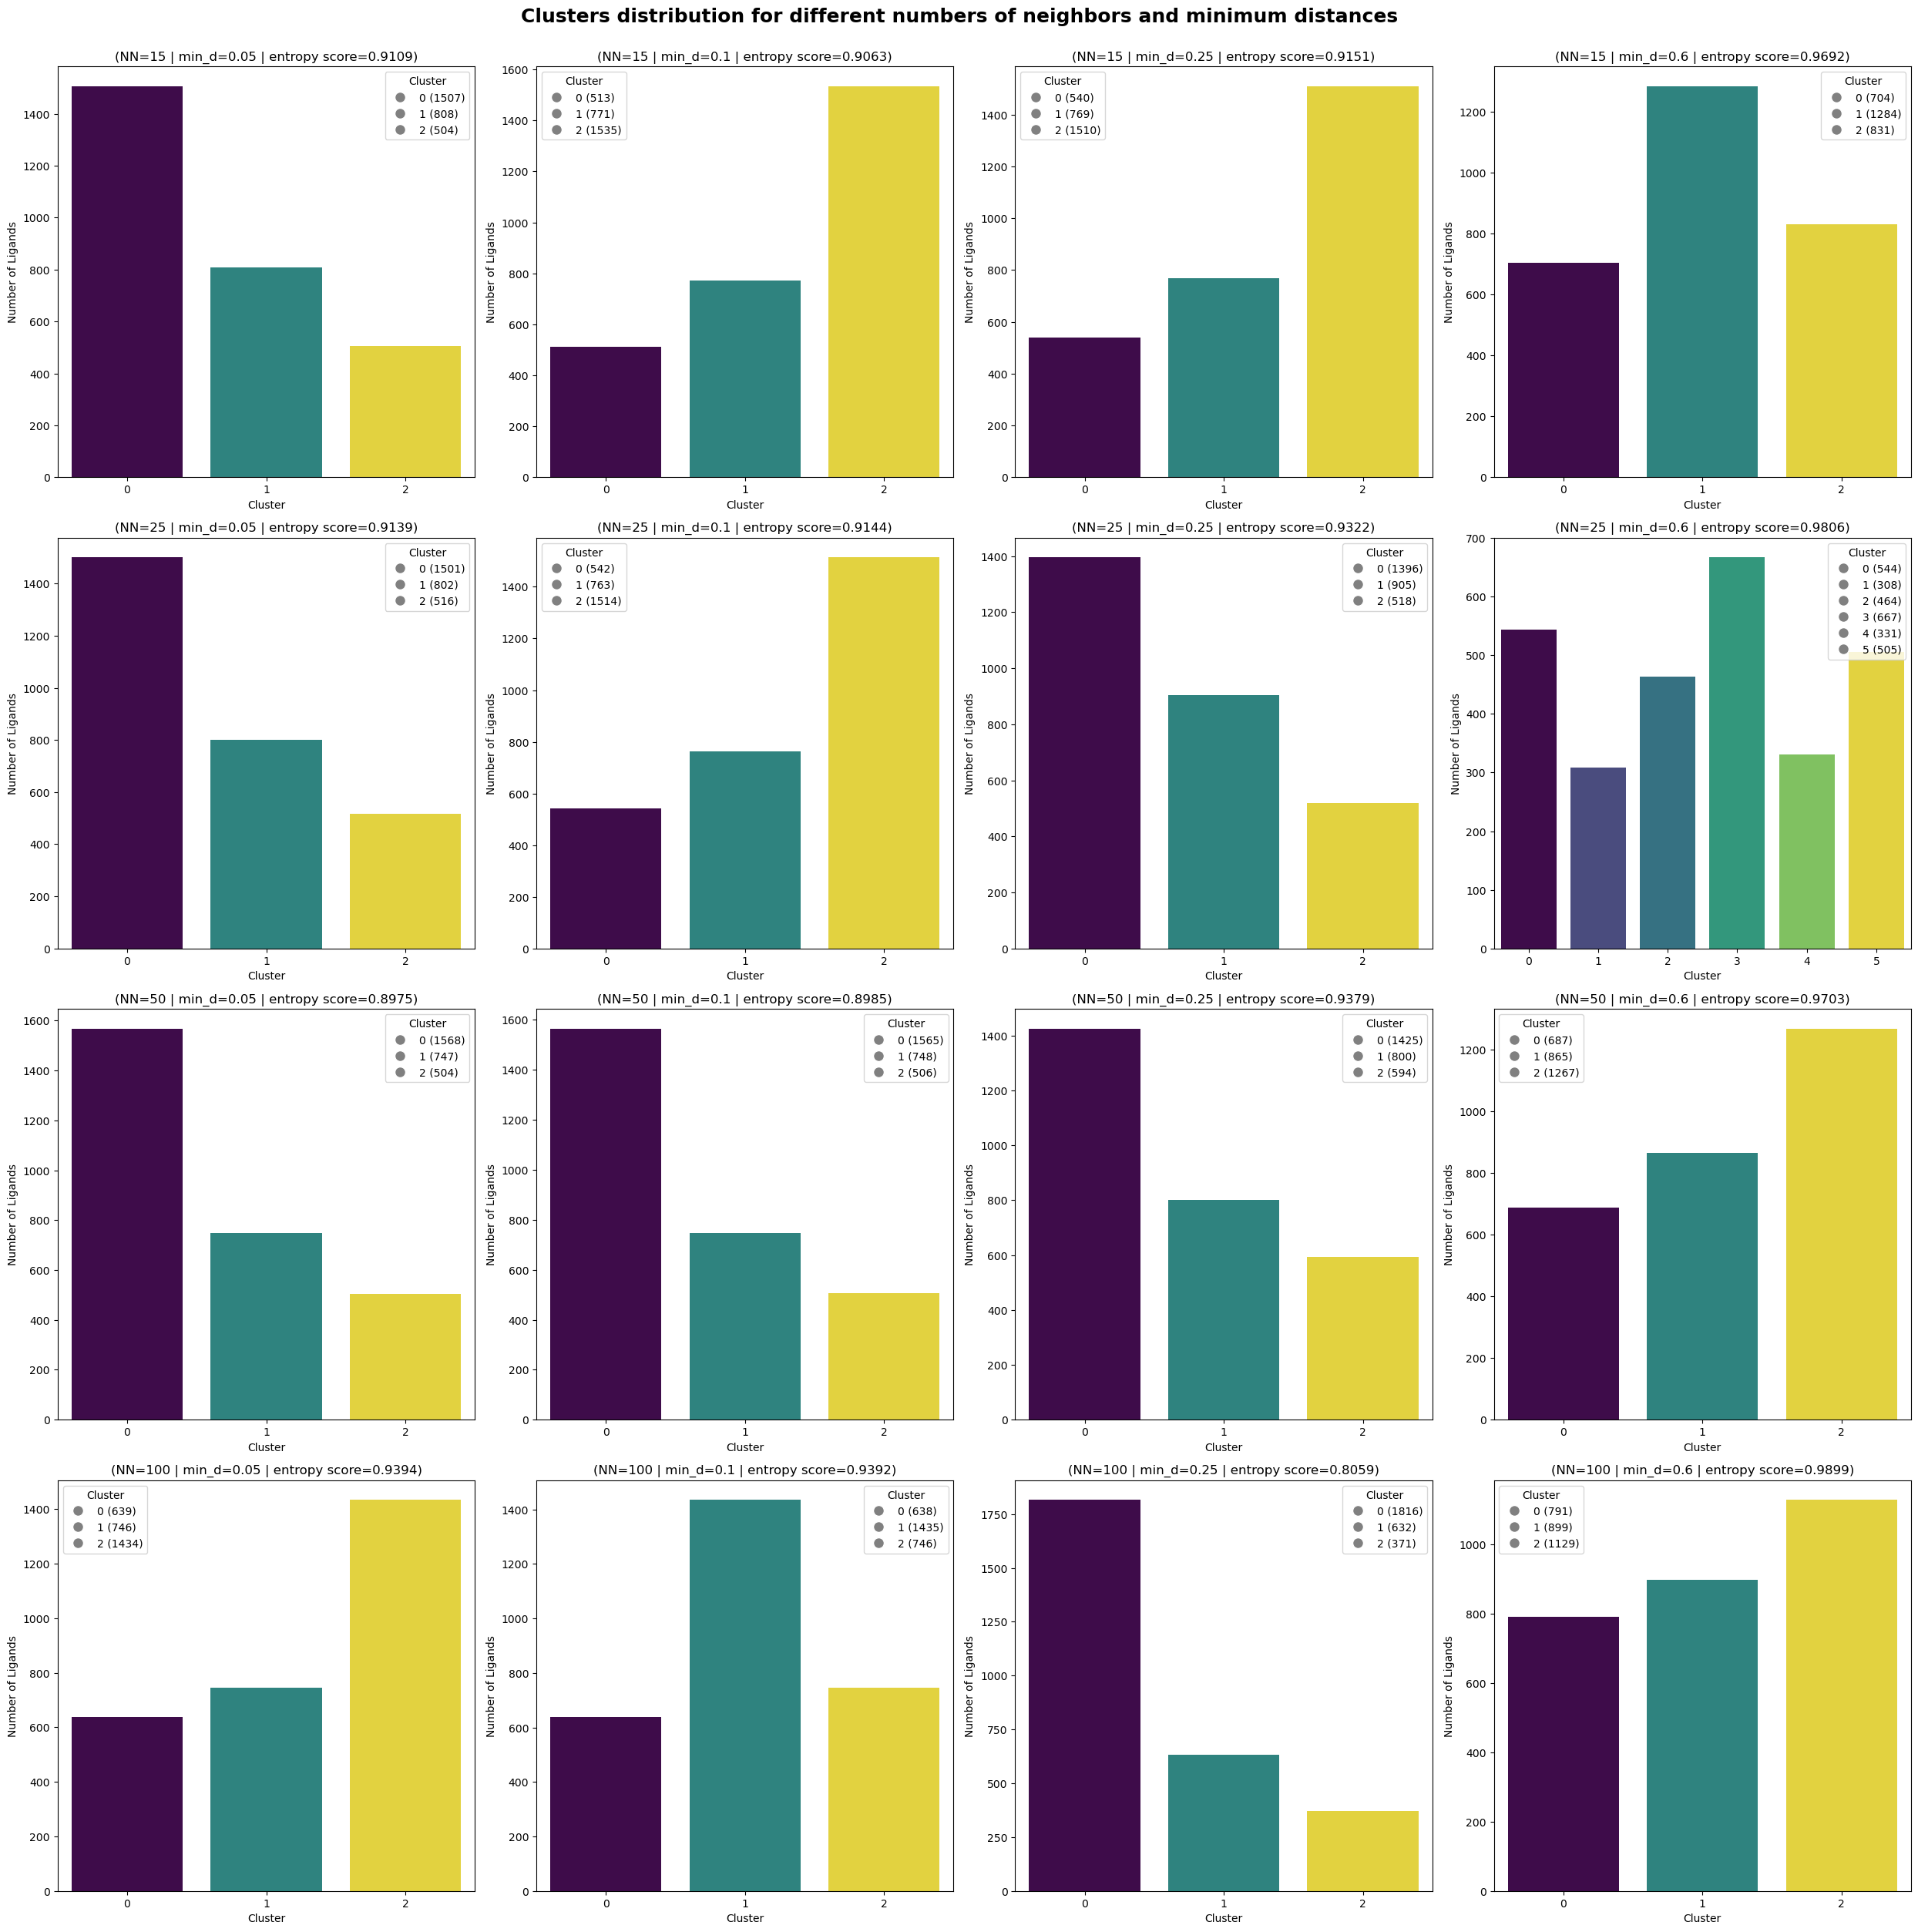

In [43]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_d', figsize=(25,25),
    title="Clusters distribution for different numbers of neighbors and minimum distances"
)

In [44]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9829623832962612
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.9824625730130528
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9848113819248532
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9831522692513486
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9763508753400507
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9755066834072335
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9758585924683522
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9726525366793037
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.9561405736141919
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.9569695445127387
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.9590068330750234
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9569041572867288
number of 

In [45]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (2,0)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [46]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 50, Minimum Distance of 0.05 with Trust Score of 0.9561405736141919


In [47]:
UMAP_BERT_df = plot_3d_clusters(umap_results, (2,0), k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using UMAP dimension reduction](test/UMAP_BERT.png)